In [ ]:
# Upscaling using Renormalization

This notebook presents how to use renromalization to upscale a 3D field of hydraulic conductivity
Three methods are used:
- Simplified renormalization
- Standard renormalization
- Tensorial renormalization

In addition, upscaling can also be performed using the standard arithmetic, harmonic or geometric means.

The renormalization method performs upscaling by iteratively upscaling small blocks of the field until the desired resolution is achieved. The upscaling of the small blocks is done using different algorithms. The simplified renormalization uses a combination of successive harmonic and arithmetic means of rows and columns of the domain. The standard renormalization solve the flow equation in small blocks of 2x2x2 cells using an electrical analog. The tensorial renormalization also solve the flow equation but with a different formulation which is generally faster than the standard renormalization.

Fore more information about renormalization and these different algorithms, please check the following paper:

Renard, P., Le Loc'h, G., Ledoux, E., De Marsily, G., & Mackay, R. (2000). A fast algorithm for the estimation of the equivalent hydraulic conductivity of heterogeneous media. Water Resources Research, 36(12), 3567-3580.

In [5]:
import sys
sys.path.append('../../')
import ArchPy.uppy
from ArchPy.uppy import upscale_k
import numpy as np
import matplotlib.pyplot as plt 
import pyvista as pv
import geone

In [6]:
pv.set_jupyter_backend("client")

In [7]:
nx = 128
ny = 128
nz = 128
dx = 2
dy = 2
dz = .4

## Generate a 3D field of hydraulic conductivity 

Random fields are generated using the geone library. The geone library is a free python package for geostatistical simulations. It is available at https://github.com/randlab/geone

In [8]:
# generate a random field
np.random.seed(3)
cm = geone.covModel.CovModel3D(elem=[("cubic", {"w":.2, "r":[100, 100, 10]})])  # covariance model (or variogram model)
sim = geone.multiGaussian.multiGaussianRun(cm, (nx, ny, nz), (dx, dy, dz), [0, 0, 0], mean=-4)

Let's also generate a topography surface for our model

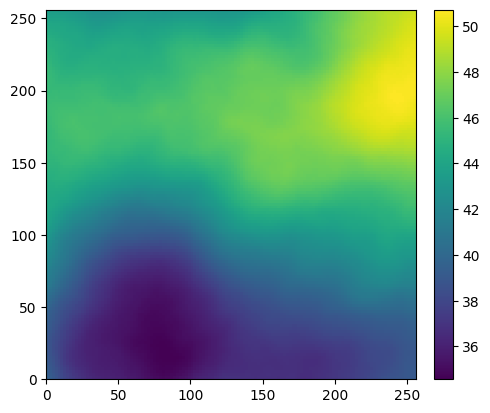

In [9]:
# simulate a topograhpy
np.random.seed(3)
cm_topo = geone.covModel.CovModel1D(elem=[("cubic", {"w":20, "r":300})])
topo = geone.multiGaussian.multiGaussianRun(cm_topo, (nx, ny), (dx, dy), [0, 0], mean=46)
geone.imgplot.drawImage2D(topo)

# values above the topography are set to nan
zg = np.arange(0, sim.val.shape[2]) * dz + dz / 2
zg = np.ones(sim.val.shape) * zg.reshape(-1, 1, 1)
sim.val = 10**np.where(zg > topo.val[:, :, None], np.nan, sim.val)


Plot the reference 3D field

In [10]:
geone.imgplot3d.drawImage3D_surface(sim, cmap="terrain")

Widget(value="<iframe src='http://localhost:65495/index.html?ui=P_0x21aa3761790_0&reconnect=auto' style='width…

Let us define factors for upscaling. This means that grid will be divided by these factors. For example, if we have a 3D field of size 100x100x100 and we want to upscale it by a factor of 2, the new field will be 50x50x50.

There are three factors: one for the x direction, one for the y direction and one for the z direction.

In [11]:
factor_x = 8
factor_y = 8
factor_z = 8

## Standard renormalization

The standard renormalization is a method that solves the flow equation in small blocks of 2x2x2 cells using an electrical analog. The equivalent hydraulic conductivity of the block is then computed and used to replace the 8 cells of the block. Two grid schemes can be used: the direct scheme and the center scheme. Center scheme is around 2x faster than the direct scheme.

### Direct scheme

In [12]:
import time

In [13]:
t1 = time.time()
field_kxx, field_kyy, field_kzz = upscale_k(sim.val[0, 0], method="standard_renormalization", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z, scheme="direct")
t2 = time.time()
t_standard_direct = t2 - t1

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
pv.set_jupyter_backend("static")

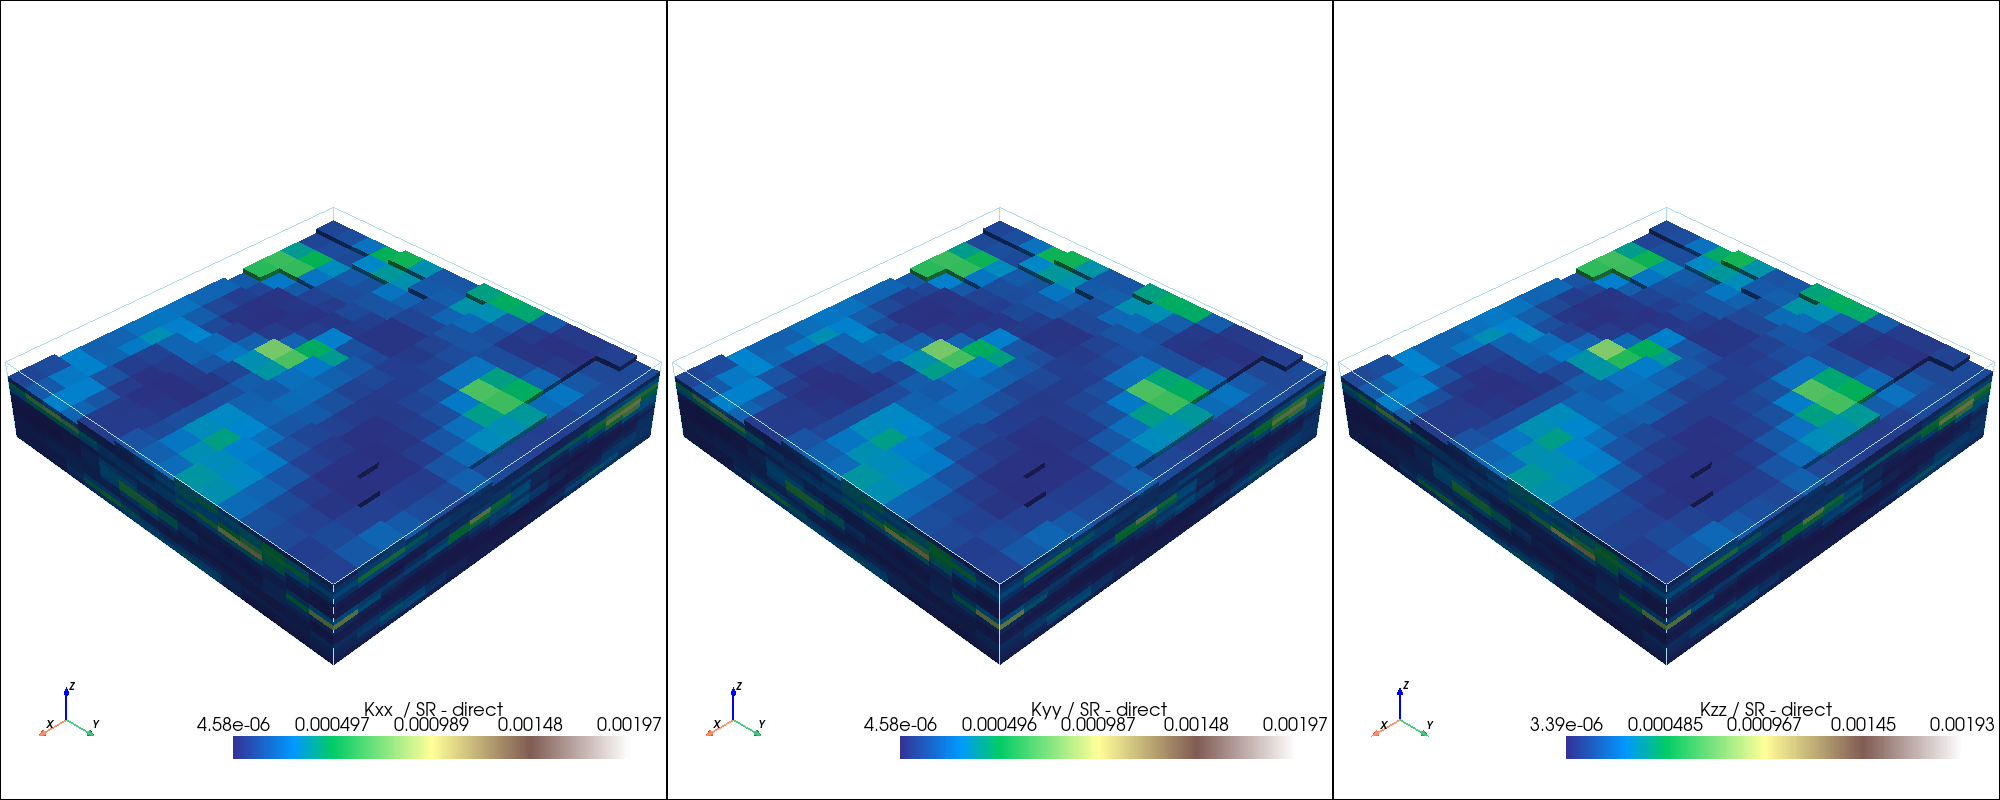

In [15]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_kxx
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kxx  / SR - direct"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_kyy
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kyy / SR - direct"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_kzz
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kzz / SR - direct"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

# pl.add_title("Standard renormalization - direct", font='times', color='k', font_size=40)
pl.show()

### Centered scheme

In [16]:
t1 = time.time()
field_kxx, field_kyy, field_kzz = upscale_k(sim.val[0, 0], method="standard_renormalization", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z, scheme="center")
t2 = time.time()
t_standard_center = t2 - t1

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


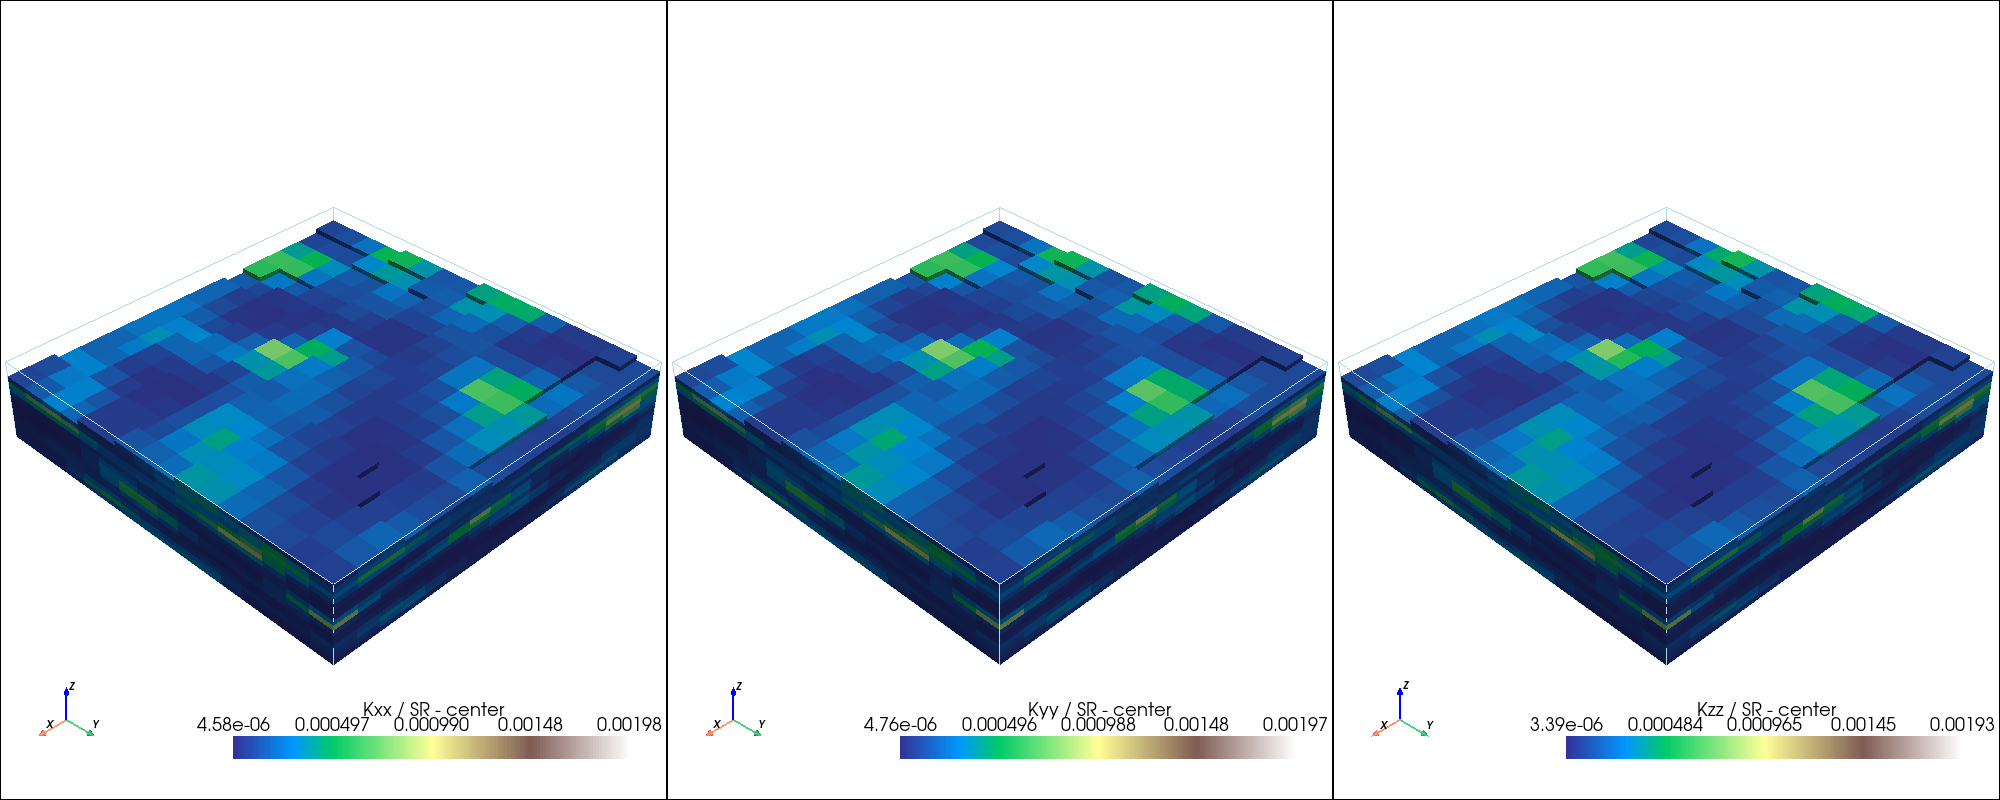

In [17]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_kxx
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kxx / SR - center"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_kyy
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kyy / SR - center"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_kzz
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kzz / SR - center"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.show()

## Tensorial renormalization

In [18]:
t1 = time.time()
field_kxx, field_kyy, field_kzz = upscale_k(sim.val[0, 0], method="tensorial_renormalization", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
t2 = time.time()
t_tensorial = t2 - t1

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


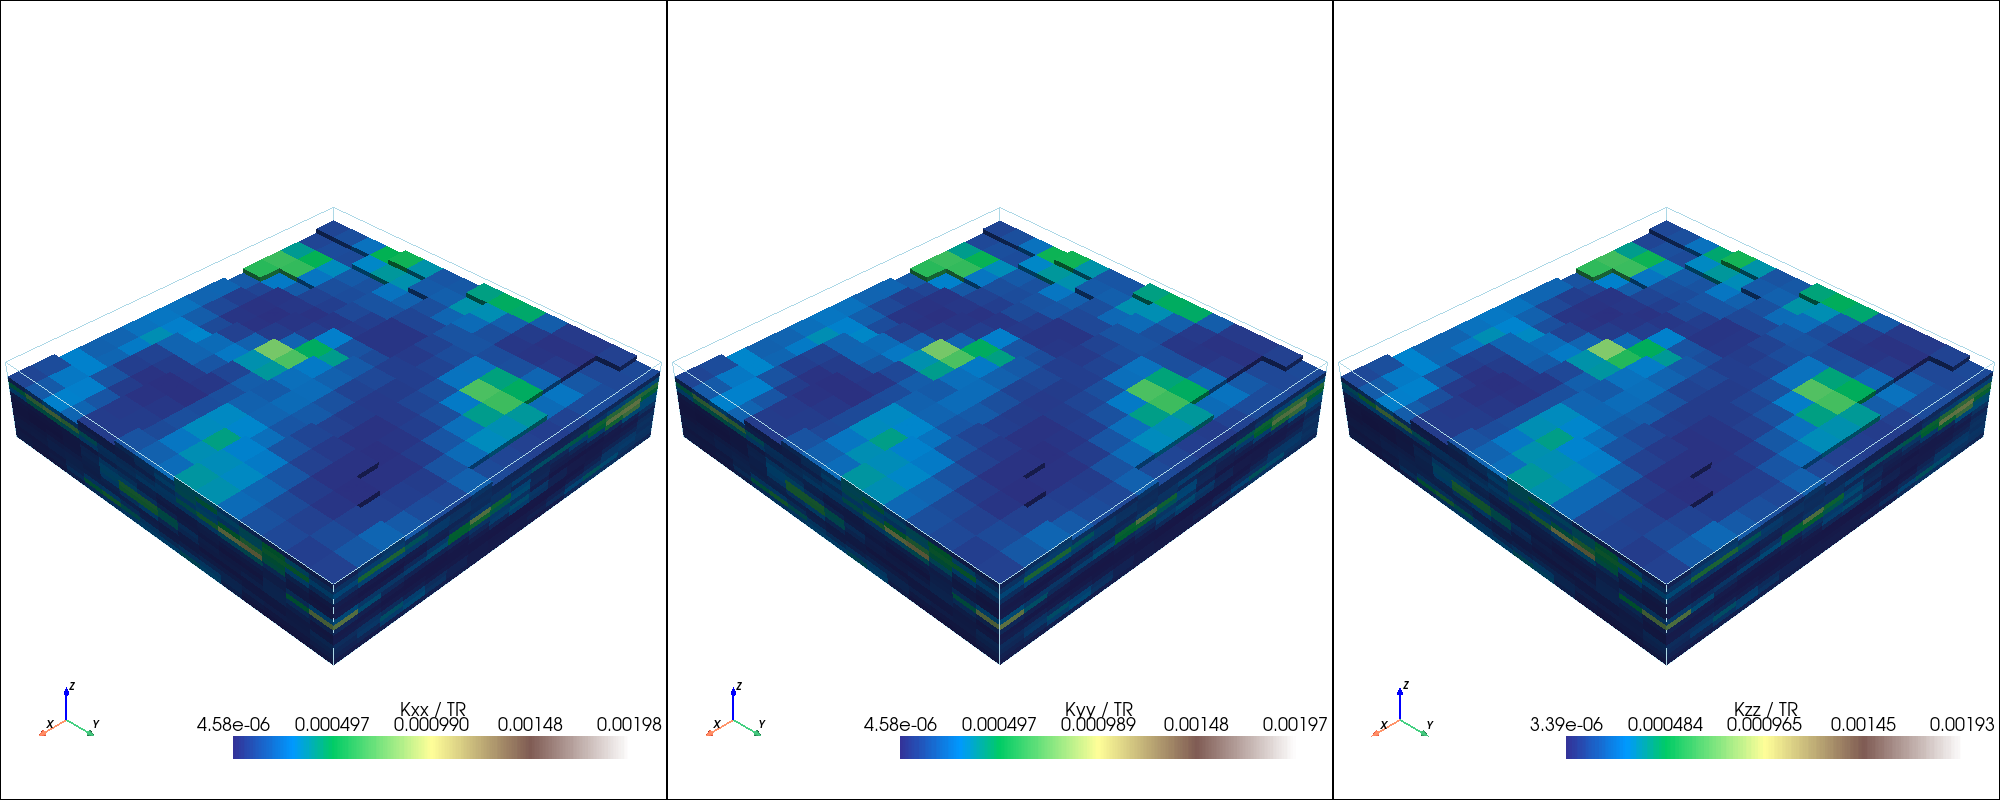

In [19]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_kxx
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kxx / TR"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_kyy
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kyy / TR"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_kzz
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kzz / TR"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.show()

## Simplified renormalization

In [20]:
t1 = time.time()
field_kxx, fieldkyy, field_kzz = upscale_k(sim.val[0, 0], method="simplified_renormalization", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
t2 = time.time()
t_simplified = t2 - t1

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


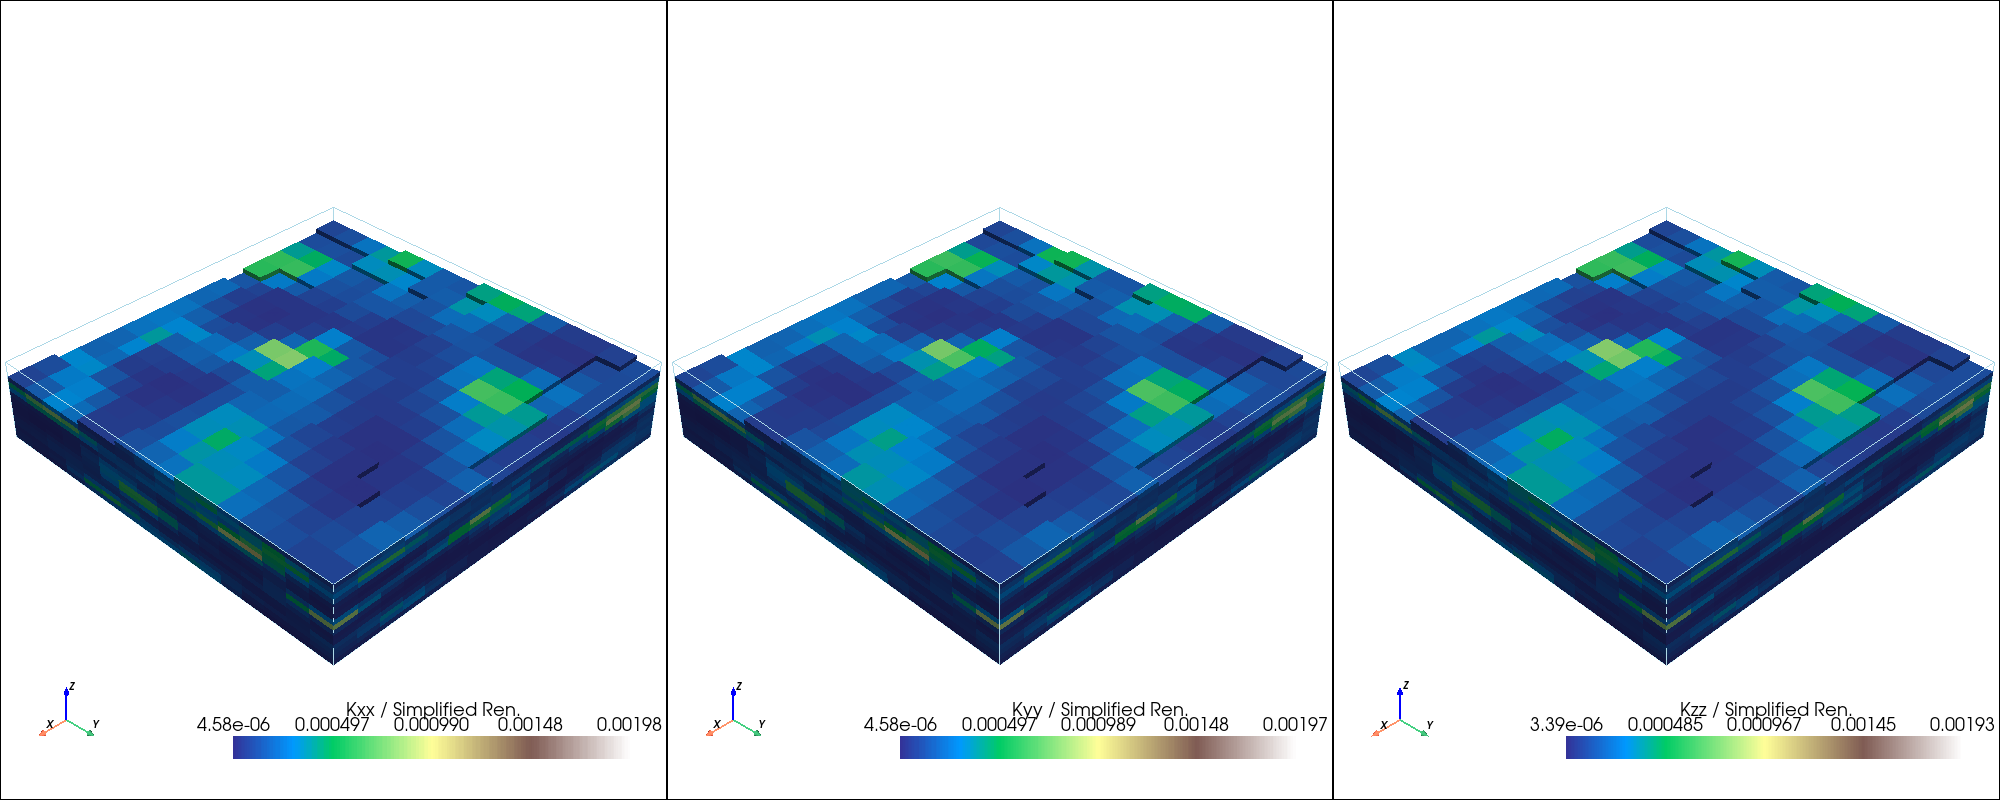

In [21]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_kxx
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kxx / Simplified Ren."])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_kyy
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kyy / Simplified Ren."])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_kzz
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kzz / Simplified Ren."])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.show()

In [22]:
t1 = time.time()
field_ari = upscale_k(sim.val[0, 0], method="arithmetic", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
t2 = time.time()
t_arithmetic = t2 - t1
field_har = upscale_k(sim.val[0, 0], method="harmonic", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
t3 = time.time()
t_harmonic = t3 - t2
field_geo = upscale_k(sim.val[0, 0], method="geometric", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
t4 = time.time()
t_geometric = t4 - t3

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


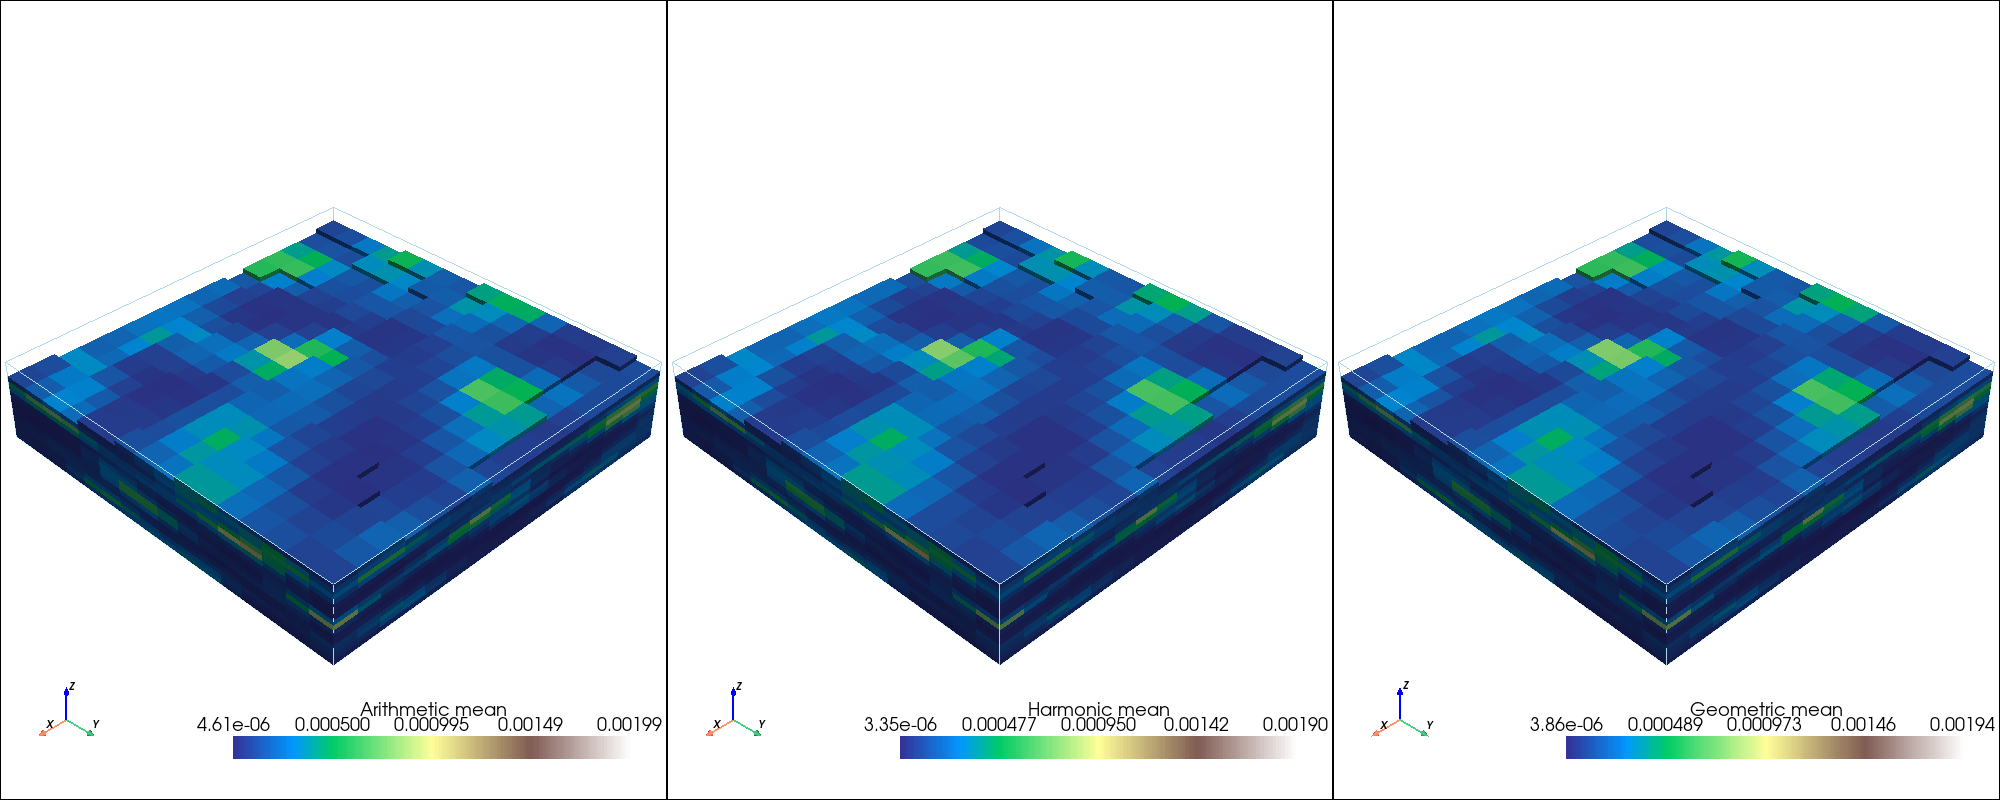

In [23]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_ari
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Arithmetic mean"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_har
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Harmonic mean"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_geo
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=dx*factor_x, sy=dy*factor_y, sz=dz*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Geometric mean"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.show()

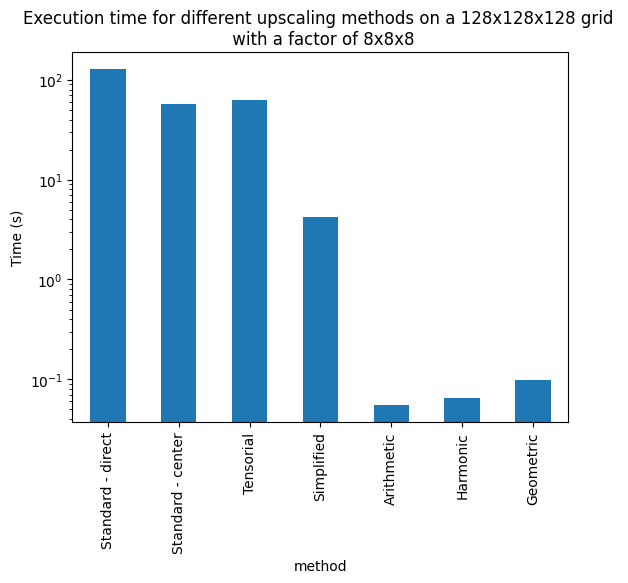

In [24]:
import pandas as pd

df = pd.DataFrame({"method": ["Standard - direct", "Standard - center", "Tensorial", "Simplified", "Arithmetic", "Harmonic", "Geometric"], "time": [t_standard_direct, t_standard_center, t_tensorial, t_simplified, t_arithmetic, t_harmonic, t_geometric]})

# plot times
df.plot.bar(x="method", y="time", legend=False, logy=True)
plt.ylabel("Time (s)")
plt.title("Execution time for different upscaling methods on a {}x{}x{} grid \n with a factor of {}x{}x{}".format(nx, ny, nz, factor_x, factor_y, factor_z))
plt.show()